In [1]:
#!pip install dtreeviz

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import dtreeviz
import graphviz
import graphviz.backend as be
from IPython.display import Image, display_svg, SVG
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.font_manager
fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()
plt.rcParams['font.family'] = 'Times New Roman'

## Loading data

In [4]:
df= pd.read_csv('../data/cleaned/data_with_outliers.csv')
df

,sqft_above,sqft_lot15,sqft_living15,waterfront,view,condition,grade,bedrooms,bathrooms,sqft_basement_cat,floors,yr_built_cat,zip,price,bathrooms_cat
0,-0.737418,-0.341970,-1.043506,0,0,3,7,3,1.00,1,1.0,1,1,221900,0
1,0.705741,0.057869,-0.294277,0,0,3,7,3,2.25,2,2.0,1,1,538000,1
2,-1.882200,0.126750,1.121919,0,0,3,6,2,1.00,1,1.0,1,0,180000,0
3,-1.038881,-0.511161,-0.994463,0,0,5,7,4,3.00,3,1.0,1,1,604000,1
4,0.125114,0.034741,-0.097540,0,0,3,8,3,2.00,1,1.0,1,0,510000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,-0.096146,-2.414324,-0.610480,0,0,3,8,3,2.50,1,3.0,2,1,360000,1
21593,0.842224,-0.018655,-0.046444,0,0,3,8,4,2.50,1,2.0,3,1,400000,1
21594,-1.115067,-1.918077,-1.977481,0,0,3,7,2,0.75,1,2.0,2,1,402101,0
21595,0.010309,-2.704055,-0.875644,0,0,3,8,3,2.50,1,2.0,2,0,400000,1


In [5]:
#divide x and y
X = df.drop(columns=["price",])
y = df["price"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

# We need to cast again into df to visualize the decision tree
X_train_df = pd.DataFrame(X_train, columns=X.columns)
#y_train_df = pd.DataFrame(y_train, columns=["Price"])

X_test_df = pd.DataFrame(X_test, columns=X.columns)
#y_test_df = pd.DataFrame(y_test, columns=["Price"])

we will fit a decision tree, we will use a crossvalidation to explore the best fitting model

In [7]:
regr = DecisionTreeRegressor(max_depth=5,
                             criterion = 'squared_error',
                             min_samples_split=2,
                             min_samples_leaf = 1,
                             max_features = 6)

In [8]:
from sklearn.model_selection import cross_validate


results = cross_validate(regr, X_train, y_train, cv = 5)
results

{'fit_time': array([0.03198266, 0.03498793, 0.0489707 , 0.06396365, 0.05797315]),
 'score_time': array([0.00599599, 0.00998521, 0.00799537, 0.0069952 , 0.00599051]),
 'test_score': array([0.61671261, 0.59379522, 0.5448904 , 0.49613658, 0.53310007])}

In [9]:
#get average of testscore
print(results['test_score'])
print("The average R2 over the folds is: {:.2f}".format(results['test_score'].mean()))

[0.61671261 0.59379522 0.5448904  0.49613658 0.53310007]
The average R2 over the folds is: 0.56


it´s poorer than the value we got in linear regression.

let´s use grid search to find a better performance

In [10]:
from sklearn.model_selection import GridSearchCV

max_depth_choices = [3,5] # max_depth lists to try
criterion_choices = ['squared_error','absolute_error'] # possible values optimization metrics list
min_samples_split_choices = [2,10] # list of possible values of min_samples_split to try
min_samples_leaf_choices = [2,10] # list of the possible values of min_samples_leaf to try

In [11]:
#create grid, which is a dictionary with hyperparameters
grid = {'max_depth': max_depth_choices,
        'criterion': criterion_choices,
        'min_samples_split': min_samples_split_choices,
        'min_samples_leaf': min_samples_leaf_choices}

In [12]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

In [13]:
#fit
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [3, 5], 'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10]})

In [14]:
#best r2
print("The best R2 for the best hyperparameters is {:.2f}".format(grid_search.best_score_))

The best R2 for the best hyperparameters is 0.58


In [15]:
print("The performace of the DecisionTree using the best gridsearchcv hyperpameters is {:.2f}".format(grid_search.best_estimator_.score(X_test, y_test)))

The performace of the DecisionTree using the best gridsearchcv hyperpameters is 0.58


In [16]:
#see the best parameter
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

check random search

In [17]:
import numpy as np

In [18]:
from sklearn.model_selection import RandomizedSearchCV

max_depth_choices= np.random.randint(low=1, high=len(X.columns), size=3) # A random integer between 1 and the number of columns
criterion_choices =  ['squared_error','absolute_error'] # A list of the possible values optimization metrics
min_samples_split_choices = np.random.randint(low=2, high=10, size=3) # A random integer between 1 and the number of columns
min_samples_leaf_choices = np.random.randint(low=2, high=10, size=3) # A random integer between 1 and the number of columns
max_features_choices = np.random.randint(low=1, high=len(X.columns), size=3) # A random integer between 1 and the number of columns

random_grid = {'max_depth': max_depth_choices,
               'criterion': criterion_choices,
               'min_samples_split': min_samples_split_choices,
               'min_samples_leaf': min_samples_leaf_choices,
               'max_features': max_features_choices}

In [19]:
model = DecisionTreeRegressor()
# n_iter is how many random combinations of hyperparameters will test use the computer.
random_search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter=25, cv = 5, n_jobs = 2)

In [20]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=25, n_jobs=2,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': array([ 2,  4, 12]),
                                        'max_features': array([13,  9,  2]),
                                        'min_samples_leaf': array([5, 2, 4]),
                                        'min_samples_split': array([6, 4, 9])})

In [21]:
random_search.best_params_

{'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_features': 9,
 'max_depth': 12,
 'criterion': 'absolute_error'}

In [22]:
print("The best R2 according to the random search is {:.2f}".format(random_search.best_score_))

The best R2 according to the random search is 0.61


In [23]:
#let´s use this model
model = DecisionTreeRegressor (min_samples_split= 10,
                               min_samples_leaf= 8,
                               max_features= 8,
                               max_depth= 9,
                               criterion= 'squared_error')


In [24]:
model.fit(X_train, y_train)
model.score(X_test, y_test).round(2)

0.61

so far it had produced the best R2 score at 0.64 for the test data, a litle above the score from randomized search . and for train set
:

In [25]:
model.score(X_train, y_train).round(2)

0.72

In [26]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [27]:
y_train_pred = [round(value, 2) for value in y_train_pred]
y_test_pred= [round(value, 2) for value in y_test_pred]

# Create a dictionary with the results
results = {
    "Set": ["Train"] * len(X_train) + ["Test"] * len(X_test),
    "Real": list(y_train) + list(y_test),
    "Predicted": y_train_pred + y_test_pred
}

# Create the results DataFrame
results_df = pd.DataFrame(results)
results_df

,Set,Real,Predicted
0,Train,515000,442892.01
1,Train,799000,838692.98
2,Train,849900,594574.38
3,Train,568000,427481.83
4,Train,1430000,601354.17
...,...,...,...
21592,Test,130000,489496.49
21593,Test,1080000,507192.64
21594,Test,1040000,818701.58
21595,Test,311100,427481.83


In [28]:
results_df.columns

Index(['Set', 'Real', 'Predicted'], dtype='object')

In [29]:
results_df['Errors'] = results_df['Real'] - results_df['Predicted']
results_df.head()

,Set,Real,Predicted,Errors
0,Train,515000,442892.01,72107.99
1,Train,799000,838692.98,-39692.98
2,Train,849900,594574.38,255325.62
3,Train,568000,427481.83,140518.17
4,Train,1430000,601354.17,828645.83


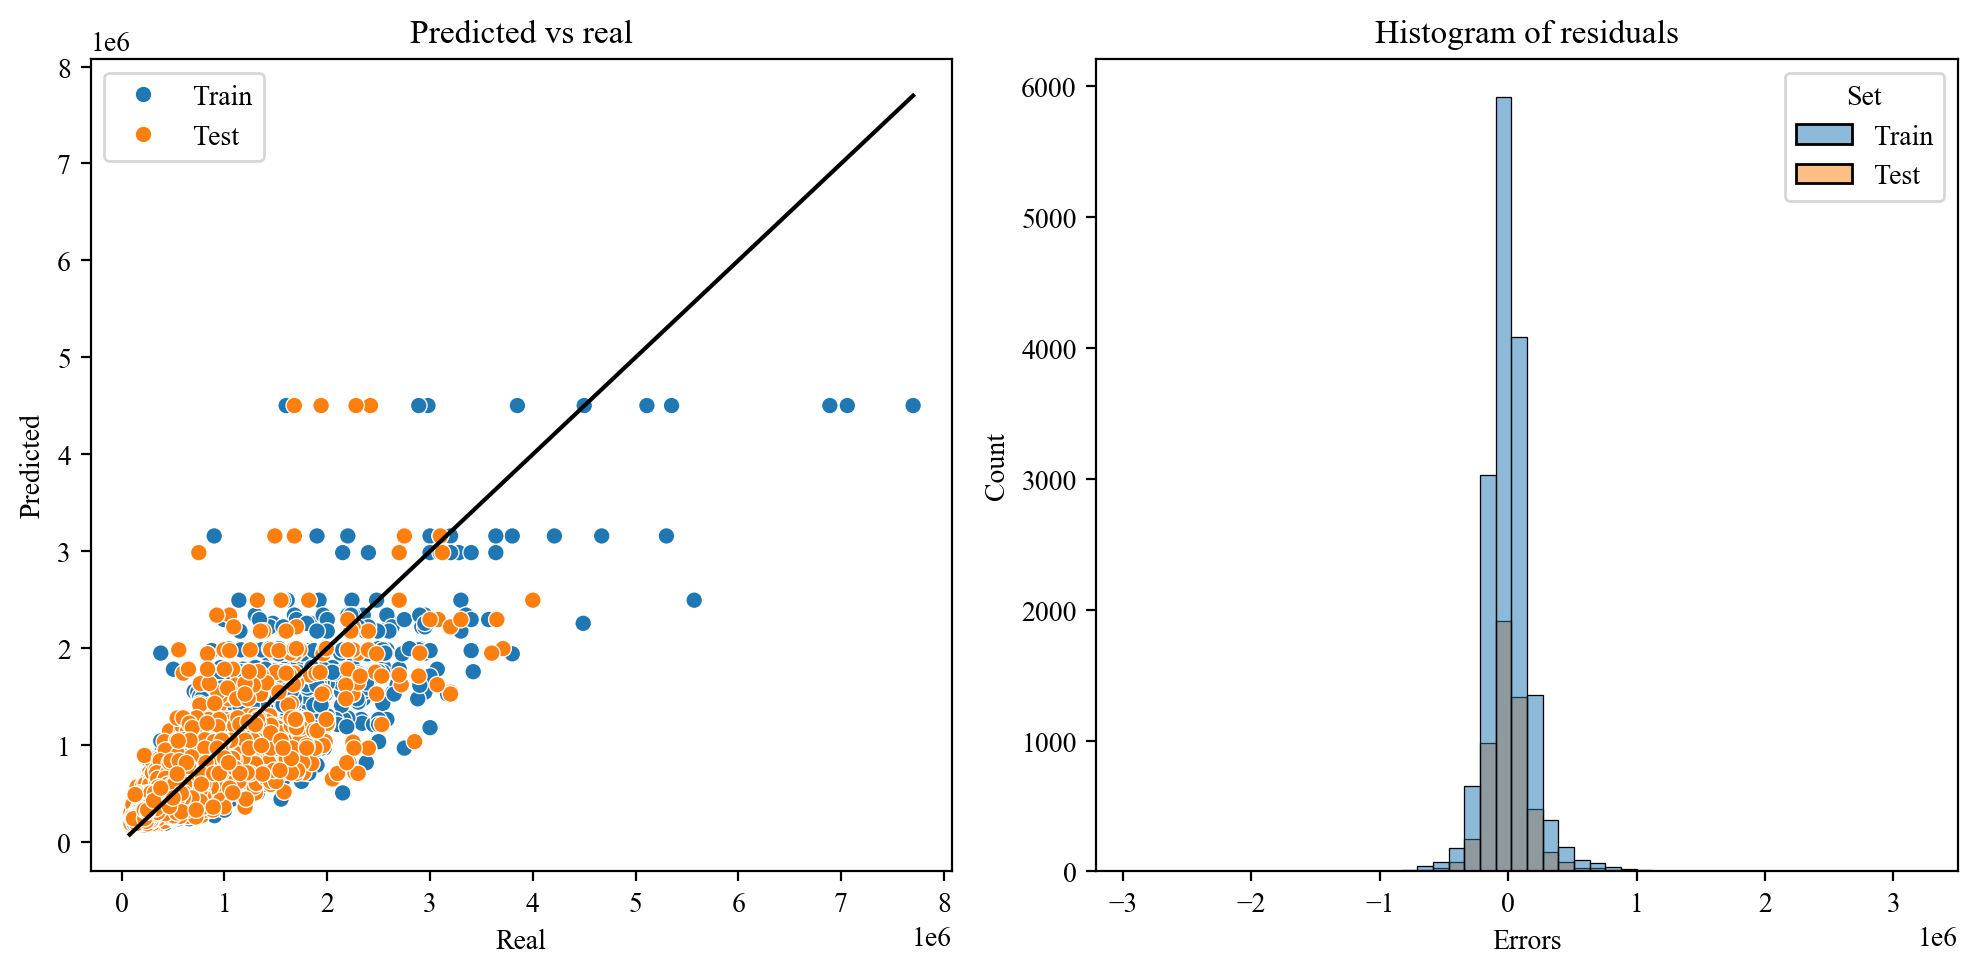

In [30]:
#visualize real and predicted
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=results_df, x="Real", y="Predicted", hue="Set", ax=ax[0])
sns.lineplot(data=results_df, x="Real", y="Real", color="black", ax=ax[0])
ax[0].set_title("Predicted vs real")
sns.histplot(results_df, x="Errors", bins=50, hue="Set", ax=ax[1])
ax[1].set_title("Histogram of residuals")

plt.tight_layout()
plt.show()

In [33]:
#import error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [31]:
def error_metrics_report(y_real_train: list, y_real_test: list, y_pred_train: list, y_pred_test: list) -> pd.DataFrame:
    '''
   The error metrics report function calculates for regression.

    Parameters:
    - y_real_train (list): The actual target values for the training dataset.
    - y_real_test (list): The actual target values for the testing dataset.
    - y_pred_train (list): The predicted target values for the training dataset.
    - y_pred_test (list): The predicted target values for the testing dataset.

    Returns:
    - metrics_df (DataFrame): A Pandas DataFrame containing error metrics for both the training and testing datasets.
    - 'Metric' (str): The name of the error metric.
    - 'Training Set' (float): The error metric value for the training set.
    - 'Testing Set' (float): The error metric value for the testing set.
    '''

    MAE_train = mean_absolute_error(y_real_train, y_pred_train)
    MAE_test  = mean_absolute_error(y_real_test, y_pred_test)

    # Mean squared error
    MSE_train = mean_squared_error(y_real_train, y_pred_train)
    MSE_test  = mean_squared_error(y_real_test, y_pred_test)

    # Root mean squared error
    RMSE_train = mean_squared_error(y_real_train, y_pred_train)
    RMSE_test  = mean_squared_error(y_real_test, y_pred_test)

    # R2
    R2_train = r2_score(y_real_train, y_pred_train)
    R2_test  = r2_score(y_real_test, y_pred_test)

    results = {"Metric":['MAE', 'MSE', 'RMSE', 'R2'] , 
               "Train": [MAE_train, MSE_train, RMSE_train, R2_train],
               "Test":  [MAE_test, MSE_test, RMSE_test, R2_test]}

    results_df = pd.DataFrame(results).round(2)

    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))


    return results_df

In [34]:
error_metrics_report(list(results_df[results_df["Set"]=="Train"]["Real"]),
                     list(results_df[results_df["Set"]=="Test"]["Real"]),
                     list(results_df[results_df["Set"]=="Train"]["Predicted"]),
                     list(results_df[results_df["Set"]=="Test"]["Predicted"]))

,Metric,Train,Test
0,MAE,125646.10,136004.50
1,MSE,38297558422.63,49045510948.62
2,RMSE,38297558422.63,49045510948.62
3,R2,0.72,0.61


In [35]:
#save error metrics
error_metrics_report(list(results_df[results_df["Set"]=="Train"]["Real"]),
                     list(results_df[results_df["Set"]=="Test"]["Real"]),
                     list(results_df[results_df["Set"]=="Train"]["Predicted"]),
                     list(results_df[results_df["Set"]=="Test"]["Predicted"])).to_csv('../data/cleaned/error_metrics_main.csv', index=False)